# Decision Tree Practice

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.tree import export_graphviz
import graphviz

In [2]:
# Helper function from Bryan
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, 
                    filled=True, feature_names=used_cols, 
                    leaves_parallel=True, node_ids=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

In [3]:
# Grabbing our data, then exploring it a bit
# Data source: https://www.kaggle.com/ronitf/heart-disease-uci
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
# Looking at our target value - what does this tell us?
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

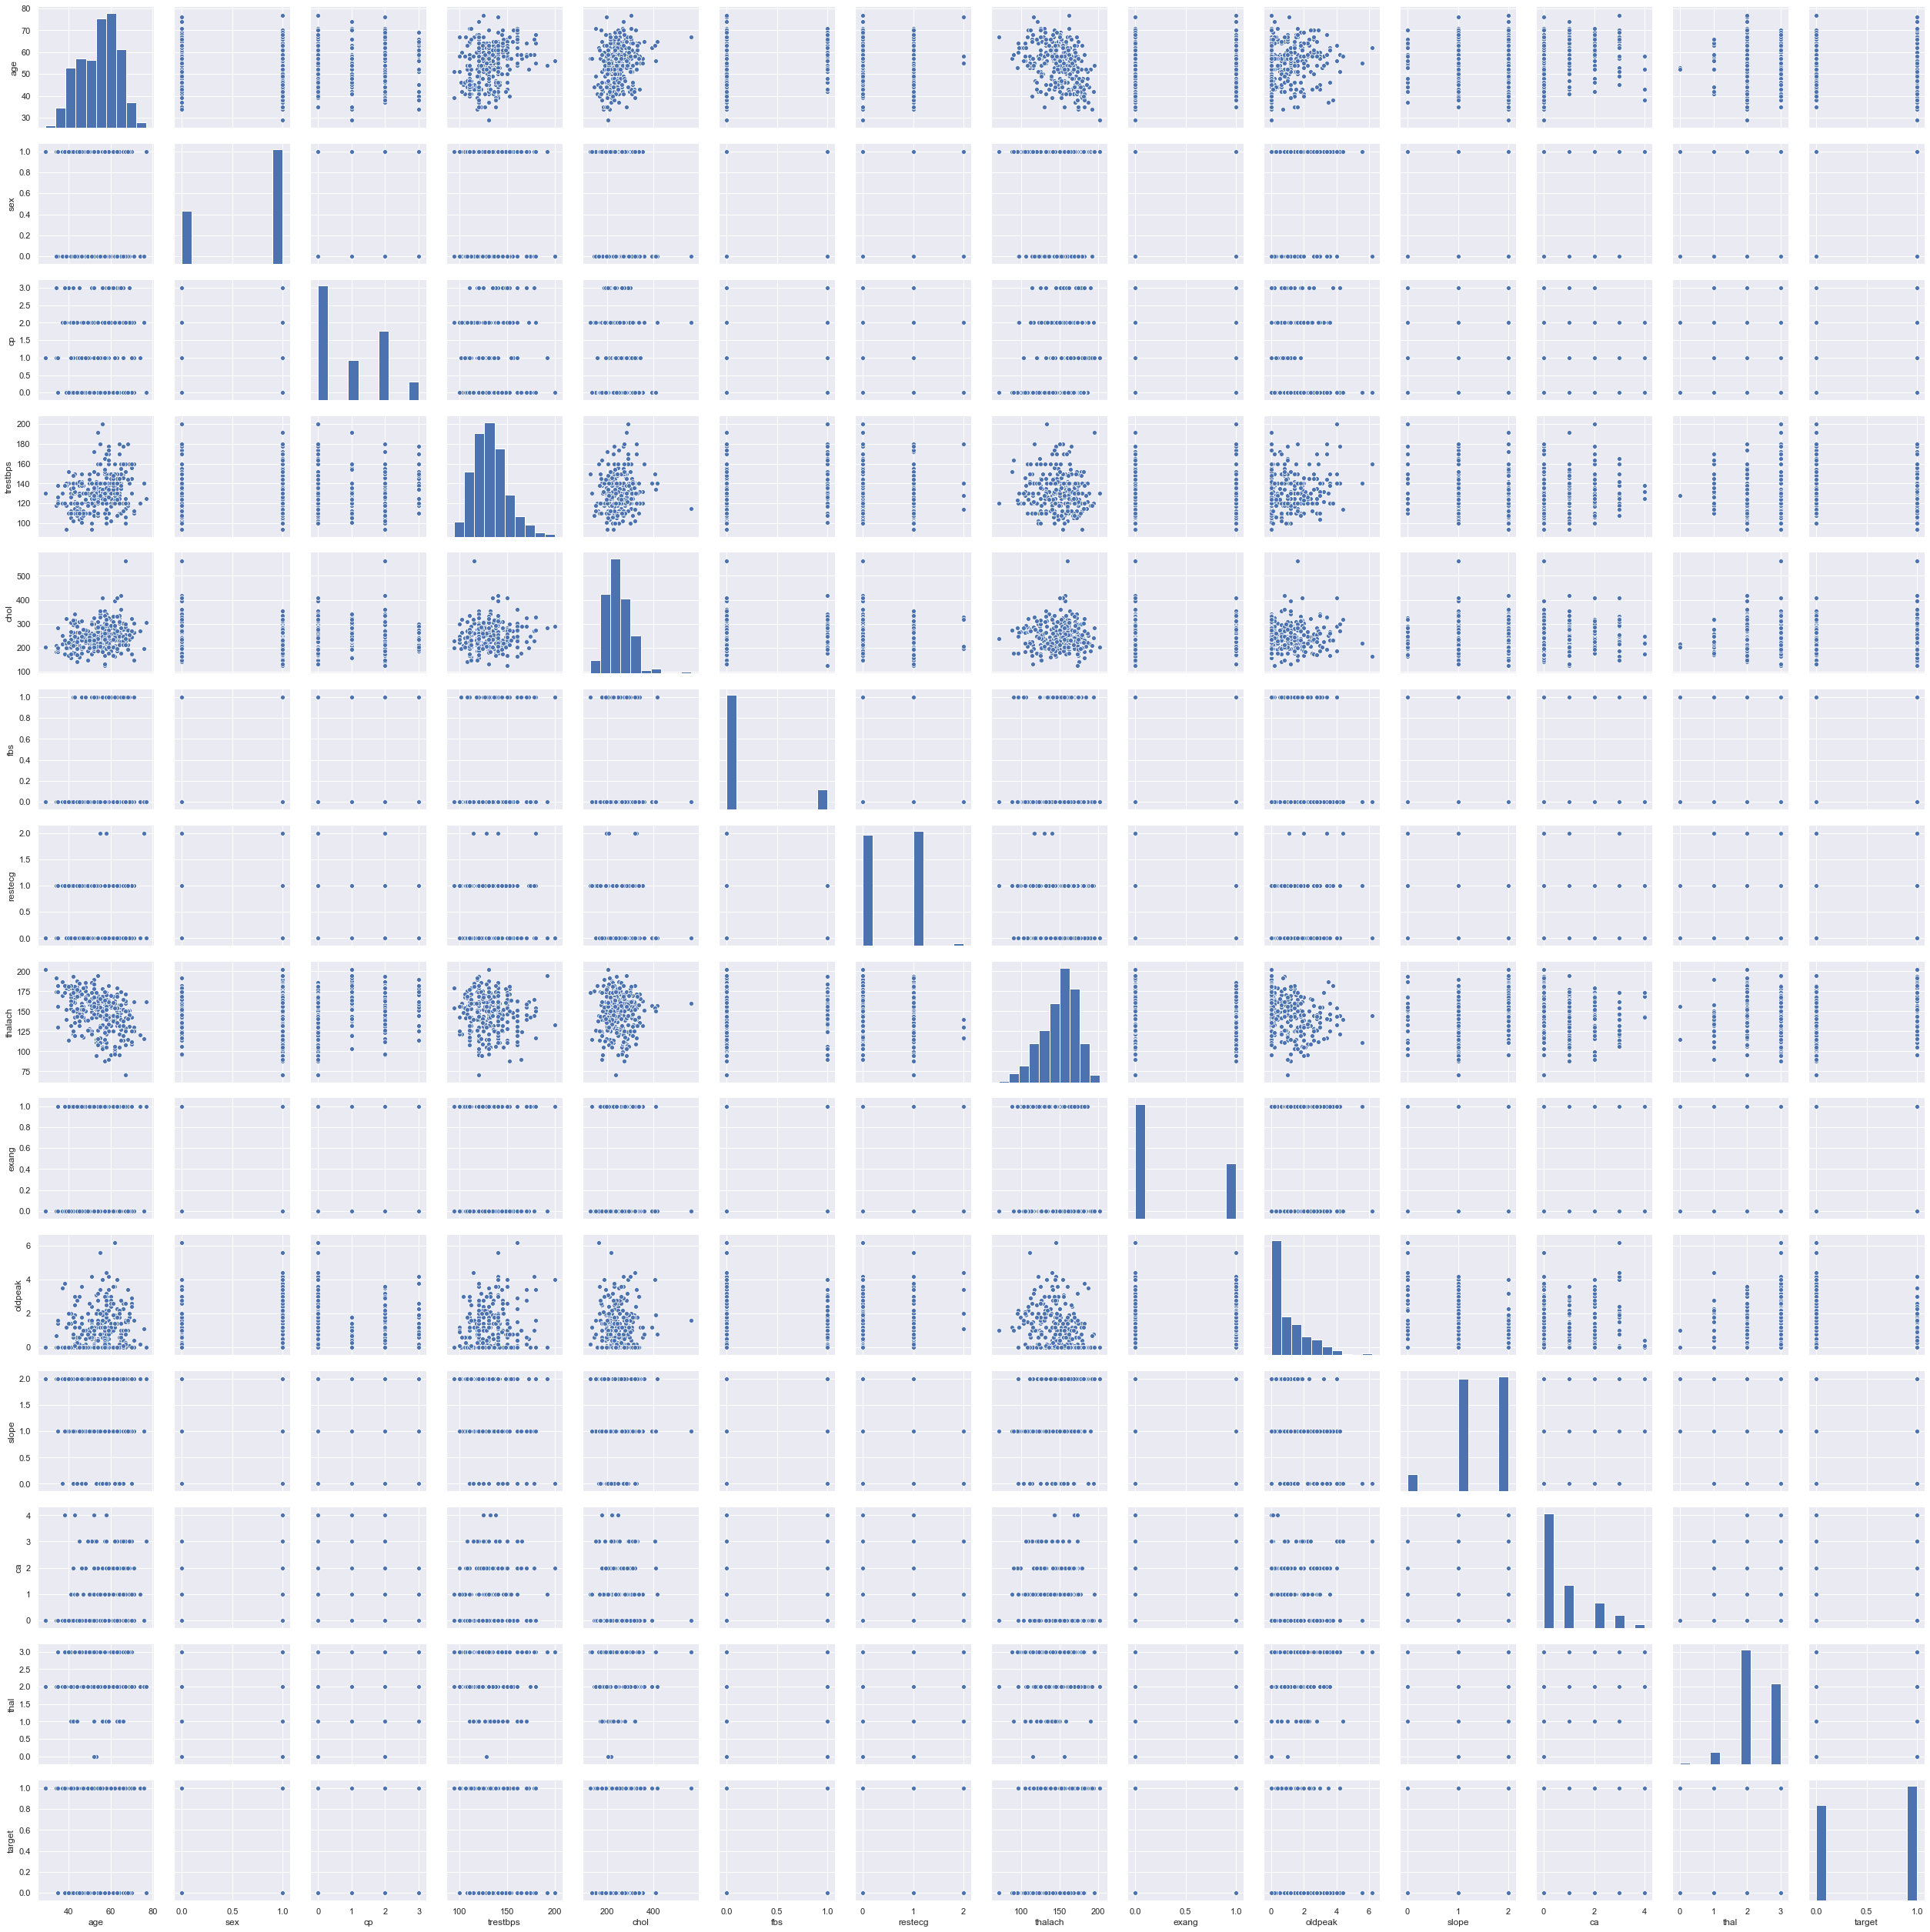

In [10]:
# Doing a pairplot for the first 11 columns - target plus variable means
sns.pairplot(df)

In [7]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [8]:
# Grabbing columns to set X and y
used_cols = [c for c in df.columns.tolist() if c not in ["target"]]
X, y = df[used_cols], df["target"]

In [9]:
# Defining our train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, 
                                                    random_state=0)

## Modeling 

### Logistic Regression

In [10]:
# Baseline: Basic logistic regression
# Using a robust scaler because the data is all on different scales
scaler = RobustScaler()
clf_lr = LogisticRegression()

pipe_lr = make_pipeline(scaler, clf_lr)

pipe_lr.fit(X_train, y_train)

train_preds = pipe_lr.predict_proba(X_train)[:,1]
test_preds = pipe_lr.predict_proba(X_test)[:,1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 0.9291959406713505
Test ROC-AUC: 0.8949964763918252


So let's evaluate the logistic regression model. How'd we do? 

- Fairly well
- Maybe a little overfit


### Decision Trees

We're going to get to modeling this data... but, before we do, let's talk about what decision trees actually DO.

In [33]:
# A simple decision tree with a single splot
dt_maxdepth2 = DecisionTreeClassifier(max_depth=2, criterion='entropy')

dt_maxdepth2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [34]:
y_train.value_counts()

1    122
0    105
Name: target, dtype: int64

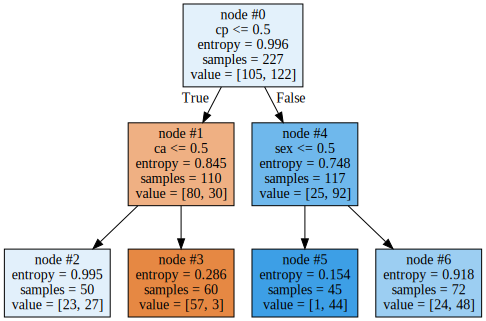

In [35]:
# Visualizing the single-split decision tree
plot_tree(dt_maxdepth2, used_cols)

Let's discuss: what is being optimized by the decision tree? What changed after the split?

- Looks at the 'purity' of the node - tries to find what distinguishes class 0 from class 1



In [51]:
# Now, let's do a basic decision tree, just the default values
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

train_preds = dt.predict_proba(X_train)[:,1]
test_preds = dt.predict_proba(X_test)[:,1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 1.0
Test ROC-AUC: 0.7973925299506696


Evaluation time! What happened?!

- Worse than baseline on test set
- WAY overfit

What can we change?

- Max_depth
- Criterion
- Max leaf nodes


In [37]:
# Okay - time to change things!
# Replace None with relevant code
dt_2 = DecisionTreeClassifier(max_depth= 5, criterion='entropy', 
                              min_samples_split=5)

dt_2.fit(X_train, y_train)

train_preds = dt_2.predict_proba(X_train)[:,1]
test_preds = dt_2.predict_proba(X_test)[:,1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 0.9761124121779858
Test ROC-AUC: 0.8379140239605356


#### Sidenote Hypothetical

Baseline Train ROC-AUC: 0.9291

Baseline Test ROC-AUC: 0.8949

_What IF??_

Train ROC-AUC: 0.9761124121779858

Test ROC-AUC: 0.9179140239605356

- Very overfit, but better than baseline: is it better?

_Mark's What IF:_

Train ROC-AUC: 0.8761124121779858

Test ROC-AUC: 0.8679140239605356

- Not overfit, but worse than baseline: is it better?

Answer: it depends!

In [47]:
# Let's also run a grid search to check a few different hyperparameters
# Replace None with relevant code
grid_params = {'class_weight': [None, 'balanced'],
               'max_depth': [4, 5, 6],
               'max_features': ["sqrt", "log2"]}

grid_search = GridSearchCV(dt, grid_params, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                 

In [48]:
grid_search.best_params_

{'class_weight': None, 'max_depth': 4, 'max_features': 'sqrt'}

In [49]:
# So let's try that!
dt_grid = grid_search.best_estimator_

dt_grid.fit(X_train, y_train)

train_preds = dt_grid.predict_proba(X_train)[:, 1]
test_preds = dt_grid.predict_proba(X_test)[:, 1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 0.9229117876658861
Test ROC-AUC: 0.8453136011275546


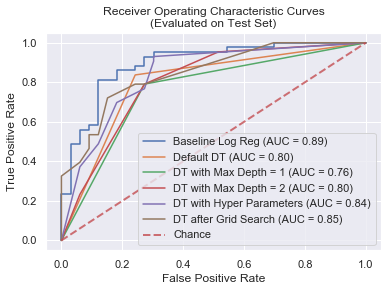

In [52]:
# Visualizing the ROCs for the models we've done
fig, ax = plt.subplots()
plot_roc_curve(pipe_lr, X_test, y_test, name="Baseline Log Reg", ax=ax)
plot_roc_curve(dt, X_test, y_test, name="Default DT", ax=ax)
plot_roc_curve(dt_maxdepth1, X_test, y_test, name="DT with Max Depth = 1", ax=ax)
plot_roc_curve(dt_maxdepth2, X_test, y_test, name="DT with Max Depth = 2", ax=ax)
plot_roc_curve(dt_2, X_test, y_test, name="DT with Hyper Parameters", ax=ax)
plot_roc_curve(dt_grid, X_test, y_test, name="DT after Grid Search", ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title("Receiver Operating Characteristic Curves\n(Evaluated on Test Set)")
ax.legend()
plt.show()

What can we learn from this visualization? Which is the best model - and how could you tell without looking at the scores?

- Baseline is still best - from both the visualization (closest to the '1' corner) and from the score



### Random Forests

In [53]:
# Moving on, let's check how a random forest does, just with default options

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

train_preds = rf.predict_proba(X_train)[:,1]
test_preds = rf.predict_proba(X_test)[:,1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 1.0
Test ROC-AUC: 0.9154334038054969


Evaluate!

- Best test score so far



In [54]:
# Now how about some hyper parameters!
# Replace None with relevant code
rf_2 = RandomForestClassifier(n_estimators = 50, max_depth=5)
rf_2.fit(X_train, y_train)

train_preds = rf_2.predict_proba(X_train)[:, 1]
test_preds = rf_2.predict_proba(X_test)[:, 1]

train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f"Train ROC-AUC: {train_score}")
print(f"Test ROC-AUC: {test_score}")

Train ROC-AUC: 0.9889149102263857
Test ROC-AUC: 0.9323467230443975


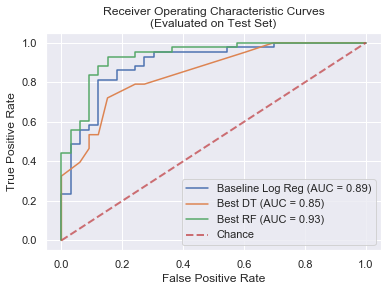

In [55]:
# Another visual of ROCs - let's use the baseline, best dt and best rf
fig, ax = plt.subplots()
plot_roc_curve(pipe_lr, X_test, y_test, name="Baseline Log Reg", ax=ax)
plot_roc_curve(dt_grid, X_test, y_test, name="Best DT", ax=ax)
plot_roc_curve(rf_2, X_test, y_test, name="Best RF", ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.title("Receiver Operating Characteristic Curves\n(Evaluated on Test Set)")
ax.legend()
plt.show()

Evaluate! Now which is better?

- 
